# The task
- We have a task, in which, at first glance, there is nothing complicated. You train any machine learning model......and get ROC-AUC metric around 0.5
- The task has a hint that we need to work with features in order to get a higher level of the metric
- The dataframe is fine, so we'll skip the preprocessing step

In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

from itertools import permutations

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from tqdm.notebook import tqdm

In [121]:
data = pd.read_csv('C:/project/files/test/dataset-circles - dataset.csv')

In [122]:
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,0.433306,-4.106981,1.252722,4.842634,7.610817,1
1,-0.216705,3.832332,-10.054348,-1.106758,1.987823,0
2,8.574821,-2.495187,5.404009,-6.219058,6.954602,1
3,7.673529,-4.234502,8.135008,3.748393,3.457908,0
4,3.548824,-2.588106,-2.095070,7.993792,-3.523852,1


Let's look at the distribution of features:

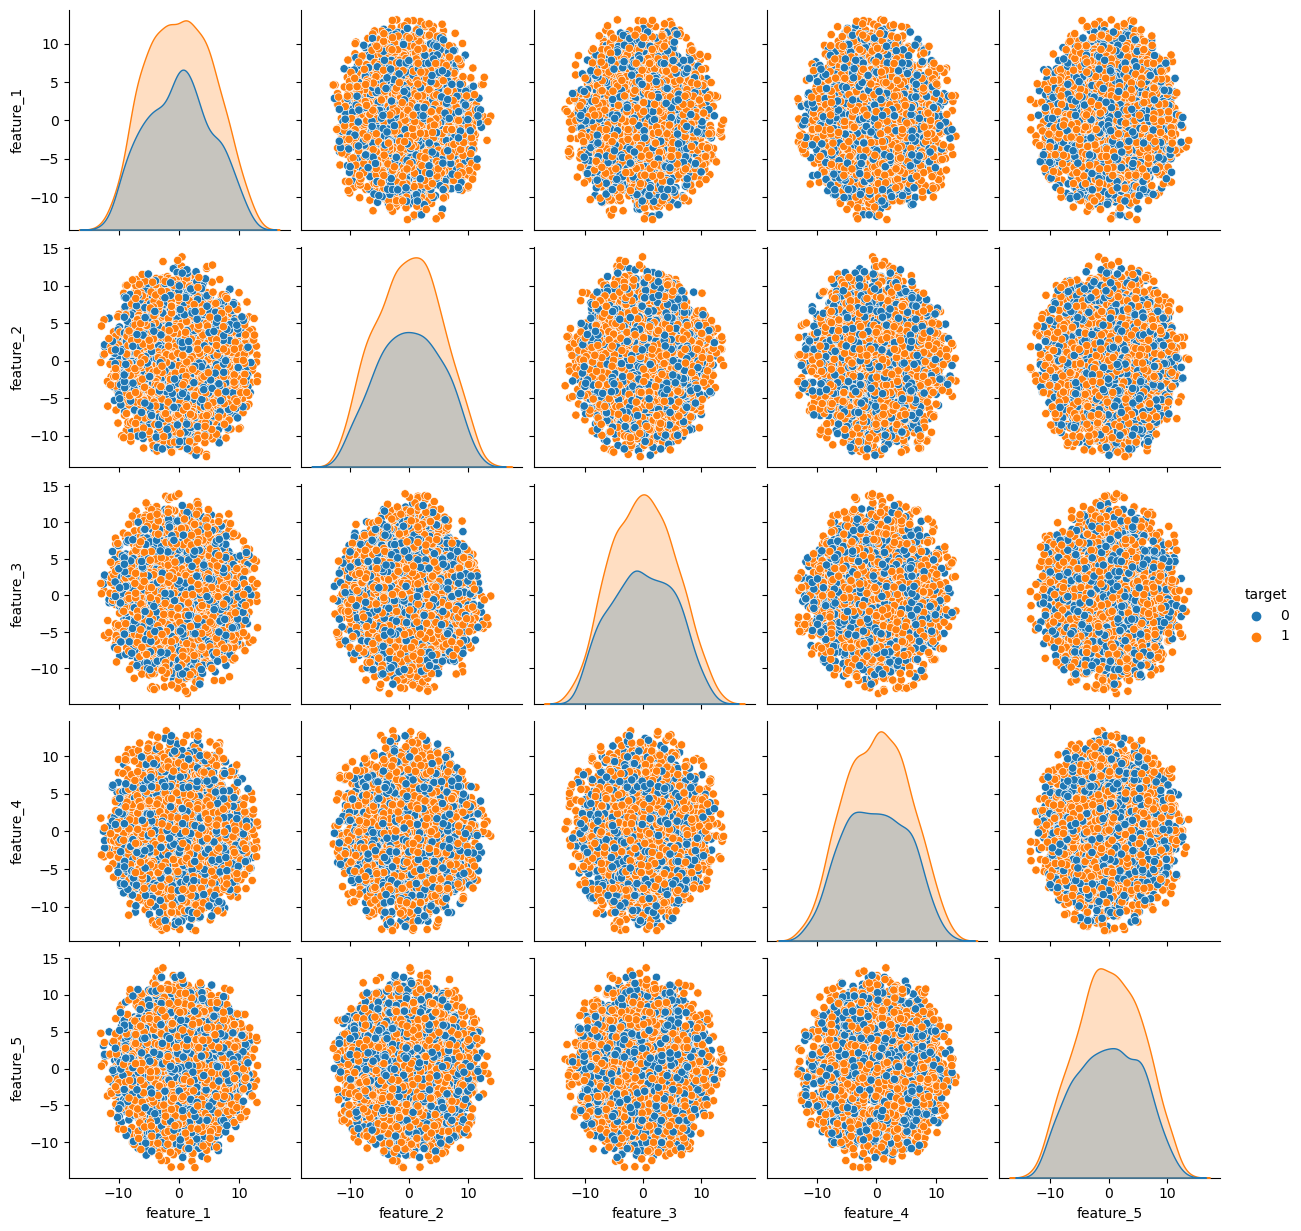

In [123]:
sns.pairplot(data, hue='target')

It should be noted that no patterns are observed. The data is normally distributed, there is no correlation between the features, no pattern is visible within the distributions relative to the target

This correlates with the description of the problem, that the model learns poorly with the current features

For further study of the data, I will make the separate dataset of features

In [124]:
features = data.drop(columns='target')
target = data['target']
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=data.columns[:-1])

Let's check the performance of the Roc-Auc metric on one of the strongest classification models:

In [125]:
%%time
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features, target)
grid_CatBoost.best_params_

CPU times: total: 12.8 s
Wall time: 11.4 s


{'iterations': 1000}

In [126]:
grid_CatBoost.best_score_

0.5193981481481481

Let's try to evaluate the importance of the parameters based on the CART Algorithm (Classification And Regression Tree)

I will wrap the function over the algorithm, since it might be useful to us later.

In [127]:
def features_evaluation(features=features, target=target):
    model = DecisionTreeClassifier(random_state=0)
    # fit the model
    model.fit(features, target)
    # get importance
    importance = model.feature_importances_
    return pd.Series(importance, index=features.columns).sort_values(ascending=False)

In [128]:
features_evaluation()

feature_4    0.216422
feature_3    0.210207
feature_2    0.204715
feature_5    0.188050
feature_1    0.180606
dtype: float64

It can be seen that all features are approximately equivalent, in fact, we cannot determine the optimal parameter for the formation of the first node of the classifier. And we already know that CatBoost does not perform well with the classification task on these features.

Let's make visualizations based on the multidimensional scaling method:

In [129]:
# This method returns the embedded points in 2D space.
# It maps points residing in a higher-dimensional space to a lower-dimensional space while 
#preserving the distances between those points as much as possible.
mds = MDS(random_state=0)
X_MSD = mds.fit_transform(features)

At this graph, we can observe the separation of classes, which is clearly related to the distances between the points of the original features

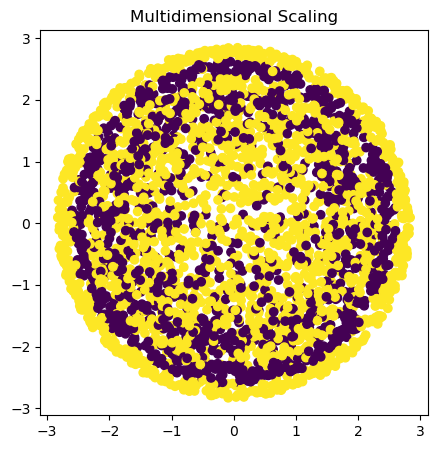

In [130]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.scatter(X_MSD[:,0], X_MSD[:,1], c=target)
ax.set_title("Multidimensional Scaling")
plt.show()

# Conclusions:
Based on the analysis, we can conclude that the features individually are very weakly related to the target. But clearly there is a superfeature (or several), calculated on the basis of current features, which can predict the target very well.
- It should be noted that I was aware of the principle by which classes are divided: this is the distance between the coordinates in five-dimensional space. The question is how to derive this analytically. Especially if the multidimensional scaling method had no effect.
- It is hardly possible to meet such task in the real world (the dataset is synthetic), at least we should have had an idea about the possible relationship of features with the target.

# New features creating algorithm
1. It is clear from the analysis, that we we need somehow to transform the features.
2. Let's make new features of basic datasets:
- multiplication of all features
- sum of all features
- paired multiplication of all features
- paired division of all features
- paired linear interactions between features (addition, subtraction)
3. Polygonal regression works well with non-linear dependencies, we can create new features using this tool.
4. The resulting datasets with features will be  evaluated using the features_evaluation() function.
5. We will check what the Roc-Auc values will be on the received datasets.
6. To the best dataset, will add 10 features from the rest and will evaluate Roc-Auc.

In [131]:
def new_features(data):
    col = data.columns
    data['mul'] = data[col].prod(axis=1)
    data['sum'] = data[col].sum(axis=1)
    comb = permutations(data[col], 2)
    for i in comb:
        data['sum'+i[0][-1]+'_'+i[1][-1]] = data[i[0]]+data[i[1]]
        data['sub'+i[0][-1]+'_'+i[1][-1]] = data[i[0]]-data[i[1]]
        data['mul'+i[0][-1]+'_'+i[1][-1]] = data[i[0]]*data[i[1]]
        data['div'+i[0][-1]+'_'+i[1][-1]] = data[i[0]]/data[i[1]]
    return data

In [132]:
# create the new features
features0 = features.copy()
features0 = new_features(features0)

features1 = features.copy()
features1 = features1.abs()
features1 = new_features(features1)

features2 = features.copy()
features2 = features2*features2
features2 = new_features(features2)

polynomial_features= PolynomialFeatures(degree=2)
features_poly = features.copy()
features_poly = pd.DataFrame(polynomial_features.fit_transform(features_poly), columns=polynomial_features.get_feature_names_out())

In [133]:
features_evaluation(features0).head()

mul          0.035829
div5_1       0.034834
div4_1       0.027776
feature_5    0.024914
div4_5       0.024371
dtype: float64

In [134]:
features_evaluation(features1).head()

sum          0.268973
mul          0.097875
feature_1    0.046327
feature_3    0.029002
feature_5    0.028191
dtype: float64

In [135]:
features_evaluation(features2).head()

sum          1.0
feature_1    0.0
sum4_1       0.0
sum4_3       0.0
div4_2       0.0
dtype: float64

In [136]:
features_evaluation(features_poly).head()

feature_1 feature_2    0.086366
feature_3 feature_5    0.067967
feature_3 feature_4    0.066514
feature_1^2            0.063029
feature_5^2            0.058523
dtype: float64

From the reports received, it can be seen that the resulting feature 'sum' (with squaring the initial features), gives a significance of 100%, this is the solution to our task:

In [137]:
temp = pd.concat([round(features2['sum'],1), target], axis=1)
temp.groupby('sum').mean().head()

,target
sum,
3.3,1.0
3.4,1.0
3.5,1.0
4.0,0.0
4.1,0.0


It is interesting what Roc-Auc we might get if we didn't find the 'sum' feature:

In [138]:
%%time
#features 0 
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features0.drop(columns='sum'), target)
grid_CatBoost.best_score_

CPU times: total: 1min 16s
Wall time: 2min 19s


0.5265925925925926

In [139]:
%%time
#features 1 full
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features1, target)
grid_CatBoost.best_score_

CPU times: total: 1min 18s
Wall time: 1min 56s


0.8297796296296297

In [140]:
%%time
#features 1 drop sum
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features1.drop(columns='sum'), target)
grid_CatBoost.best_score_

CPU times: total: 1min 18s
Wall time: 1min 56s


0.6799518518518519

In [141]:
%%time
#features 2 full
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features2, target)
grid_CatBoost.best_score_

CPU times: total: 1min 18s
Wall time: 1min 56s


1.0

In [142]:
%%time
#features 2 drop sum
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features2.drop(columns='sum'), target)
grid_CatBoost.best_score_

CPU times: total: 1min 17s
Wall time: 1min 46s


0.7959185185185185

In [143]:
%%time
#features poly
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features_poly, target)
grid_CatBoost.best_score_

CPU times: total: 24.5 s
Wall time: 28.9 s


0.5489388888888889

The best Roc-Auc (without sum feature) was achieved on features and it was 0.797

Let's try to add top features from the other features datasets to the features2:

In [144]:
features_final = features2.drop(columns='sum')
features_final = features_final.join(features0[features_evaluation(features0.drop(columns='sum')).head(10).index], rsuffix='_F0')
features_final = features_final.join(features1[features_evaluation(features1.drop(columns='sum')).head(10).index], rsuffix='_F1')
features_final = features_final.join(features_poly[features_evaluation(features_poly).head(10).index], rsuffix='_FP')

In [145]:
%%time
# features_final
model = CatBoostClassifier(silent=True)
param_grid={'iterations':[1000]}

grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
grid_CatBoost.fit(features_final, target)
grid_CatBoost.best_score_

CPU times: total: 1min 41s
Wall time: 2min 21s


0.7700148148148147

The weaker features are added to the final features_final file, the worse the Roc-Auc. This can be fixed by changing the depth, min_data_in_leaf or max_leaves hyperparameters, but we will go the other way and will reduce the number of features in the features_final file:

In [146]:
best_score = 0
best_number = 0
for number in tqdm([4,5,6,7,8,9,10,11,15,20,30]):
    temp = features_final[features_evaluation(features_final).head(number).index]
    model = CatBoostClassifier(silent=True)
    param_grid={'iterations':[1000]}
    grid_CatBoost = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', cv=4, n_jobs=-1)
    grid_CatBoost.fit(temp, target)
    if grid_CatBoost.best_score_ >best_score:
        best_score = grid_CatBoost.best_score_
        best_number = number       
    print(f'score:{grid_CatBoost.best_score_}, number:{number}')
print(f'best_score:{best_score}, best_number:{best_number}') 
print(features_evaluation(features_final).head(best_number))

  0%|          | 0/11 [00:00<?, ?it/s]

score:0.8338416666666667, number:4
score:0.8805185185185186, number:5
score:0.8665055555555556, number:6
score:0.8766444444444444, number:7
score:0.8747277777777778, number:8
score:0.8811833333333333, number:9
score:0.8785185185185185, number:10
score:0.8666981481481483, number:11
score:0.841911111111111, number:15
score:0.8270037037037037, number:20
score:0.8118111111111111, number:30
best_score:0.8811833333333333, best_number:9
sum4_1       0.052194
sum3_5       0.050356
sum5_3       0.041800
sum4_2       0.039153
sum1_2_F1    0.033083
mul_F1       0.030471
sum2_1       0.026341
sum1_2       0.025371
sum2_4       0.023936
dtype: float64


# Conclusions:

We achieved a Roc-Auc of 0.88. I think that by selecting of hyperparameters, it would be possible to slightly improve the result, but this is not the purpose of this work.

There is another point more interesting here. The first top 5 features are related to the summation of the initial features. This is a good hint to make summation more complicated: sum by 3, 4 and finally sum all the features together. 

Hyperlink to original solution https://www.youtube.com/watch?v=aNREIdJ3IuY&list=PLQJ7ptkRY-xbefSg1XN3FA-SdSRFcCQfn&index=1&t=6s